# **Understanding KNN (K Nearest Neighbors) Through A Simple Classification Problem**

### **Libraries used**

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import itertools
import pprint
import random
import tqdm
import csv

from sklearn.metrics import confusion_matrix
from collections import Counter, defaultdict
from typing import NamedTuple, List, Dict
from typing import List, Literal
from statistics import mean

from scratch.data_preprocessing import split_data, print_classification_report
from scratch.metrics import accuracy, precision, recall, f1_score
from scratch.linear_algebra import distance
from scratch.complex_typing import Vector

### **Introduction**

The K-Nearest Neighbors (KNN) algorithm is a supervised learning model used for both classification and regression. It is one of the simplest and most intuitive machine learning algorithms.

KNN predicts the label of a new input by looking at the ‘k’ closest labeled examples in the training dataset. It assumes that similar instances are likely to have similar labels.
- For classification, it returns the most common class among the neighbors.
- For regression, it returns the average of the neighbors’ values.

It doesn't really need a training phase because does not build an internal model or learn any parameters, instead it just stores the entire training dataset.

Keep reading to explore the step-by-step process of a knn clustering process and see it in action with practical examples.

### **Theoretical Framework**

**How does KNN work?**

Given a new point x, KNN works as follows:

1. Compute distance between x and all points in the training set.
2. Select the k nearest neighbors (lowest distances).
3. Aggregate their labels:
    - Classification: majority vote.
    - Regression: mean value.
4. Return the predicted label or value.

Remember that all the training set is storage in the model (there is no really a training phase just a storage.)

**What about the distances**

Distance metrics are used to quantify how “close” or “far apart” two vectors are within a feature space, and they play a key role in many machine learning algorithms just as this. Below is a list of the most simple used distance calculations.

1. Euclidean distance:<br>
The “straight-line” distance between two vectors:

$$
d(\mathbf{x}, \mathbf{y}) = \sqrt{ \sum_{i=1}^{n} (x_i - y_i)^2 }
$$

2. Manhattan Distance:<br>
Measures the total absolute difference between the components of two vectors. It is called “Manhattan” (or taxicab distance) because it mimics the way a taxi would drive through a city laid out in a grid — moving only in horizontal and vertical directions.<br>
The total absolute difference across all dimensions:

$$
d(\mathbf{x}, \mathbf{y}) = \sum_{i=1}^{n} |x_i - y_i|
$$

### **Practical exercise**

**Data understanding**

First, let’s introduce the dataset we’ll be working with. The Iris dataset is a well-known classic in machine learning, and it will serve as a helpful guide throughout our journey in understanding K-Nearest Neighbors (KNN) models.

The **Iris dataset** is a classic and widely used dataset in machine learning and statistics. It was introduced by Ronald A. Fisher in 1936 and is often used for classification and clustering tasks.

It contains 150 samples from 3 species of the Iris flower:
- Setosa
- Versicolor
- Virginica

Each sample is described by 4 numeric features (measured in centimeters):

| Feature Name   | Description                       | Unit     |
|----------------|-----------------------------------|----------|
| sepal_length   | Length of the sepal               | cm       |
| sepal_width    | Width of the sepal                | cm       |
| petal_length   | Length of the petal               | cm       |
| petal_width    | Width of the petal                | cm       |

Let’s start by loading the dataset:

In [ ]:
class LabeledPoint(NamedTuple):
    """
    This is a class that represent a LabeledPoint, we will
    have a list with many LabeledPoints each one will have 
    internally two attributes: 
    1. point: A vector with the values of each feature
    2. label: the label of each point
    """
    point: Vector
    label: str
    
def parse_iris_row(row: List[str]) -> LabeledPoint:
    """
    This function is used to convert the input data of the .dat file
    into LabeledPoints described above.
    sepal_length, sepal_width, petal_length, petal_width, class"
    """
    measurements = [float(value) for value in row[:-1]]
    label = row[-1].split("-")[-1]
    return LabeledPoint(measurements, label)

# Generate the data
with open('datasets/iris.dat') as f:
    reader = csv.reader(f)
    iris_data = [
        parse_iris_row(row) 
        for row in reader 
        if row and any(cell.strip() for cell in row)
    ]

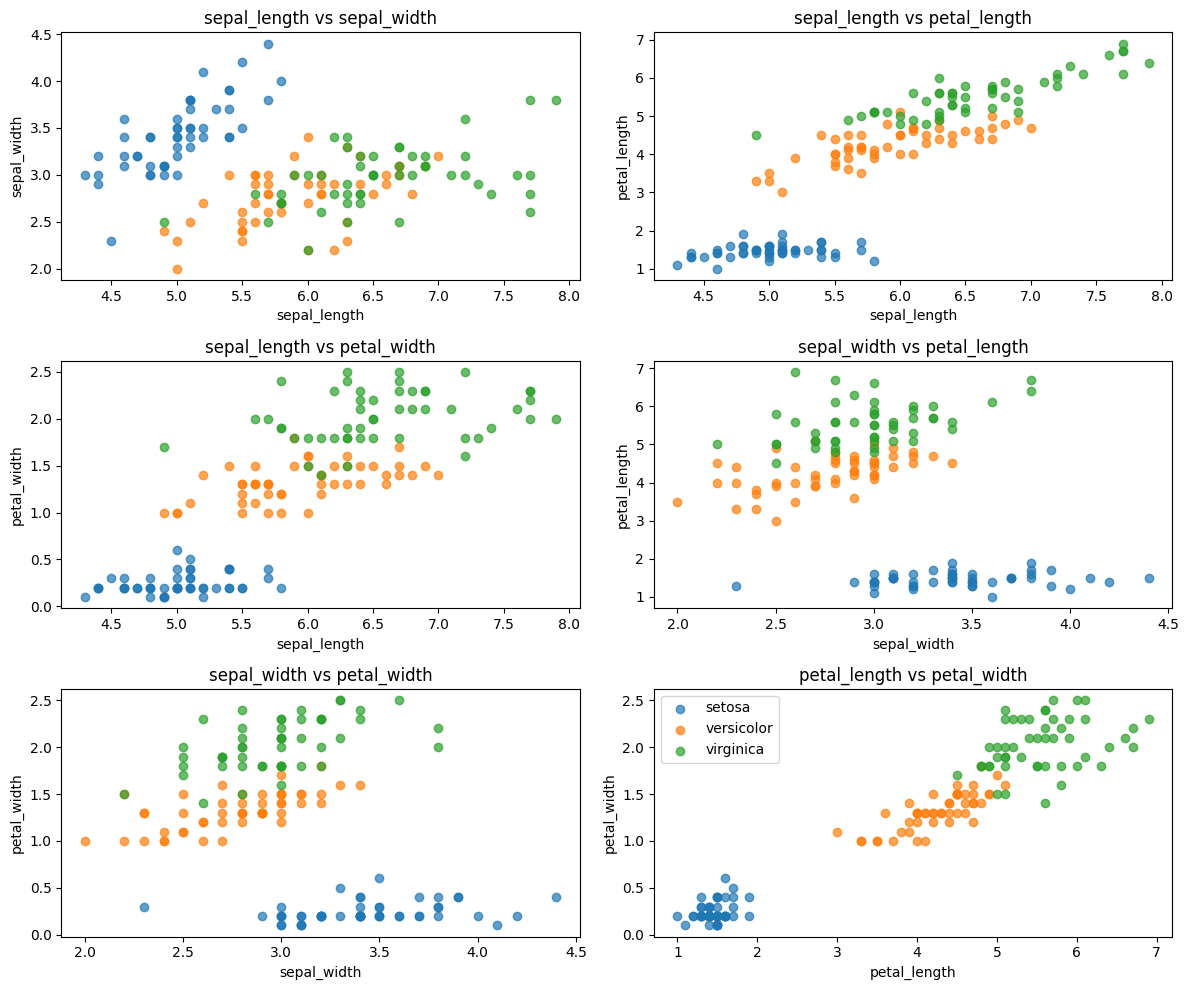

In [3]:
# Convert to DataFrame
df = pd.DataFrame([{
    'sepal_length': lp.point[0],
    'sepal_width': lp.point[1],
    'petal_length': lp.point[2],
    'petal_width': lp.point[3],
    'label': lp.label
} for lp in iris_data])

# List of feature names
features = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']

# Create scatter plots for all pairs of features
plt.figure(figsize=(12, 10))
plot_num = 1

for i in range(len(features)):
    for j in range(i + 1, len(features)):
        plt.subplot(3, 2, plot_num)
        for label in df['label'].unique():
            subset = df[df['label'] == label]
            plt.scatter(subset[features[i]], 
                        subset[features[j]], label=label, alpha=0.7)
        plt.xlabel(features[i])
        plt.ylabel(features[j])
        plt.title(f'{features[i]} vs {features[j]}')
        plot_num += 1

plt.tight_layout()
plt.legend()
plt.show()

In most of the plots, we can clearly observe the presence of distinct groups, indicating that the features effectively separate the different species.

**Code implementation**

Now let's make the code for the classifier. Remember you can find the code of all of this in the current repo (src/scratch) and you even import using <br>

<a href="https://github.com/RGaRo/ds-foundations.git" style="color:blue; text-decoration:underline;">
pip install git+https://github.com/RGaRo/ds-foundations.git@master
</a>

Remember all of this code is just for academical purposes, and thera are currently better and more efficient solutions just like scikit-learn implementations.

In [4]:
class KNNClassifier:
    """A class to represent a KNN model."""

    def __init__(self, k: int = 5):
        """
        k: How many neighbours you want consider
        """
        self.labeled_points: List[LabeledPoint] = []
        self.k = k

    def fit(self, labeled_points: List[LabeledPoint]):
        """Store labeled points for KNN classification."""
        self.labeled_points = labeled_points

    def predict(self, new_point: Vector):
        """Predict the label of a new point.
        new_point: Vector you want to predict
        """
        # We got the labeled pointes ordered by distance
        ordered_labeled_points = sorted(
            self.labeled_points,
            key=lambda x: distance(x.point, new_point),
        )
        ordered_labels = [
            labeled_point.label
            for labeled_point in ordered_labeled_points
        ]

        tiebreaker_counter = 0
        winners_count = 0
        while winners_count != 1:
            # Getting the labels in order
            k_nearest_labels = [
                label
                for label in ordered_labels[
                    : self.k - tiebreaker_counter
                ]
            ]

            # Define the winner label
            k_nearest_labels_counter = Counter(k_nearest_labels)
            frecuencies = [i for i in k_nearest_labels_counter.values()]
            max_frecuencies = max(frecuencies)
            winners_count = len(
                [i for i in frecuencies if i == max_frecuencies]
            )

            tiebreaker_counter += 1
        return k_nearest_labels_counter.most_common(1)[0][0]
    def _cm(self, test_dataset: List[LabeledPoint]) -> Dict[str, float]:
        """ Get the confusion matrix of each label
            Cols - Predicted
            Rows - Actual
        """
        real_labels = [lp.label for lp in test_dataset]
        predicted_labels = [self.predict(lp.point) for lp in test_dataset]
        labels = sorted(list(set(real_labels + predicted_labels)), reverse=True)
        cm = confusion_matrix(real_labels, predicted_labels, labels=labels)
        
        cm_detailed = defaultdict(dict)
        for label_index in range(len(labels)):
            tp = 0
            tn = 0
            fp = 0
            fn = 0
            for row in range(len(labels)):
                for col in range(len(labels)):
                    if row==label_index and col==label_index:
                        tp += int(cm[row][col])
                    elif row==label_index and col!=label_index:
                        fn += int(cm[row][col])
                    elif row!=label_index and col==label_index:
                        fp += int(cm[row][col])
                    elif row!=label_index and col!=label_index:
                        tn += int(cm[row][col])

            cm_detailed[labels[label_index]]['tp'] = tp
            cm_detailed[labels[label_index]]['tn'] = tn
            cm_detailed[labels[label_index]]['fp'] = fp
            cm_detailed[labels[label_index]]['fn'] = fn

        return labels, cm, cm_detailed
    
    def metrics(self ,test_dataset: List[LabeledPoint], kind: Literal['micro','macro'] = 'micro') -> Dict[str, float]:
        labels, cm, cm_detailed = self._cm(test_dataset)
        # If just two labels we get the simpler confusion matrix and got metrics
        if len(labels) == 2:
            tp = cm_detailed[labels[0]]['tp']
            fp = cm_detailed[labels[0]]['fp']
            fn = cm_detailed[labels[0]]['fn']
            tn = cm_detailed[labels[0]]['tn']
            _accuracy = float(np.trace(cm)/np.sum(cm))
            _precision = precision(tp, fp)
            _recall = recall(tp, fn)
            _f1_score = f1_score(tp, tn, fp, fn)

            return {
                "labels": labels,
                "confusion_matrix": cm,
                "confusion_matrix_detailes": cm_detailed,
                "accuracy": _accuracy, 
                "precision": _precision, 
                "recall": _recall,
                "f1_score": _f1_score
            }
        
        # If multilabeled predictions we got micro or macro metrics
        if len(labels) > 2:
            _accuracy = float(np.trace(cm)/np.sum(cm))
            if kind == 'micro':
                tp = sum([cm_detailed[label]['tp'] for label in labels])
                fp = sum([cm_detailed[label]['fp'] for label in labels])
                fn = sum([cm_detailed[label]['fn'] for label in labels])
                tn = sum([cm_detailed[label]['tn'] for label in labels])
                _precision = precision(tp, fp)
                _recall = recall(tp, fn)
                _f1_score = f1_score(tp, tn, fp, fn)

            elif kind == 'macro':
                _precision = mean(
                    [
                        precision(
                            cm_detailed[label]['tp'],
                            cm_detailed[label]['fp']
                        )
                        for label in labels
                    ]
                
                )

                _recall = mean(
                    [
                        recall(
                            cm_detailed[label]['tp'],
                            cm_detailed[label]['fn']
                        )
                        for label in labels
                    ]
                
                )

                _f1_score = mean(
                    [
                        f1_score(
                            cm_detailed[label]['tp'],
                            cm_detailed[label]['tn'],
                            cm_detailed[label]['fp'],
                            cm_detailed[label]['fn']
                        )
                        for label in labels
                    ]
                
                )

            else:
                raise AssertionError('Not a valid kind of metrics, use kind = "micro" or kind = "macro"')
            
            return {
                "labels": labels,
                "confusion_matrix": cm,
                "confusion_matrix_detailes": cm_detailed,
                "accuracy": _accuracy, 
                "precision": _precision, 
                "recall": _recall,
                "f1_score": _f1_score
            }


In this example we are just implementing the euclidean distance of the linear algebra module.

**Application**

Getting a model up and running is as simple as initializing an instance and fitting it with the training dataset.
In the case of K-Nearest Neighbors (KNN), this process stores the entire training dataset inside the model, allowing it to make predictions based on the nearest neighbors of any given input.

Once the model is ready, we can evaluate its performance using a test dataset. The model will generate predictions for the test samples, and we can then compute several commonly used evaluation metrics:
- Accuracy: The proportion of correct predictions out of all predictions made.
- Precision: The proportion of true positive predictions among all predicted positives (i.e., how many predicted positives were actually correct).
- Recall: The proportion of true positives identified out of all actual positives (i.e., how well the model finds all relevant cases).
- F1 Score: The harmonic mean of precision and recall — useful when you want a balance between both.

In [5]:
# Set a random seed, it let us repeat the exercise
random.seed(12)

# Spliting the data into a 80% for training and 20% for validation
train_iris, test_iris = split_data(iris_data, 0.80)

# Initialize an instance of the model
knn_model = KNNClassifier()

# Fit the instance with the training dataset
knn_model.fit(train_iris)

Let's see how good the metrics are. 

When evaluating how good your classification model is — especially for multi-class problems — you can summarize performance using micro and macro metrics.

| Metric Type | How It Works                                      | TP/FP/FN Used?             | Best When...                        |
|-------------|---------------------------------------------------|----------------------------|-------------------------------------|
| Micro       | Uses total TP, FP, FN across all classes          | Global totals              | You care about **overall** performance |
| Macro       | Average of per-class metrics (Precision, Recall, F1 Score)  | Per class then averaged    | You care about **each class equally**  |

In [6]:
micro_metrics = knn_model.metrics(test_iris, kind = 'micro')
print("Micro metrics")
print_classification_report(micro_metrics)

Micro metrics

=== Classification Report ===
Labels: ['virginica', 'versicolor', 'setosa']

Confusion Matrix:
  11   0   0
   1  10   0
   0   0   8

Detailed Confusion Metrics per Class:
  virginica    -> TP: 11, TN: 18, FP:  1, FN:  0
  versicolor   -> TP: 10, TN: 19, FP:  0, FN:  1
  setosa       -> TP:  8, TN: 22, FP:  0, FN:  0

Overall Metrics:
  Accuracy : 0.9667
  Precision: 0.9667
  Recall   : 0.9667
  F1 Score : 0.9667


In [7]:
macro_metrics = knn_model.metrics(test_iris, kind = 'macro')
print("Micro metrics")
print_classification_report(macro_metrics)

Micro metrics

=== Classification Report ===
Labels: ['virginica', 'versicolor', 'setosa']

Confusion Matrix:
  11   0   0
   1  10   0
   0   0   8

Detailed Confusion Metrics per Class:
  virginica    -> TP: 11, TN: 18, FP:  1, FN:  0
  versicolor   -> TP: 10, TN: 19, FP:  0, FN:  1
  setosa       -> TP:  8, TN: 22, FP:  0, FN:  0

Overall Metrics:
  Accuracy : 0.9667
  Precision: 0.9722
  Recall   : 0.9697
  F1 Score : 0.9696


These numbers are great and indicate to us a great generalization. Now let's make something graphically using the test dataset.

1. First we have to make the predictions and got everything into a dataframe

In [8]:
df_test_iris = pd.DataFrame([{
    'sepal_length': lp.point[0],
    'sepal_width': lp.point[1],
    'petal_length': lp.point[2],
    'petal_width': lp.point[3],
    'real_label': lp.label
} for lp in test_iris])

predictions = [knn_model.predict(test_point.point) for test_point in test_iris]

# Add the list as a new column
df_test_iris['predicted_label'] = predictions

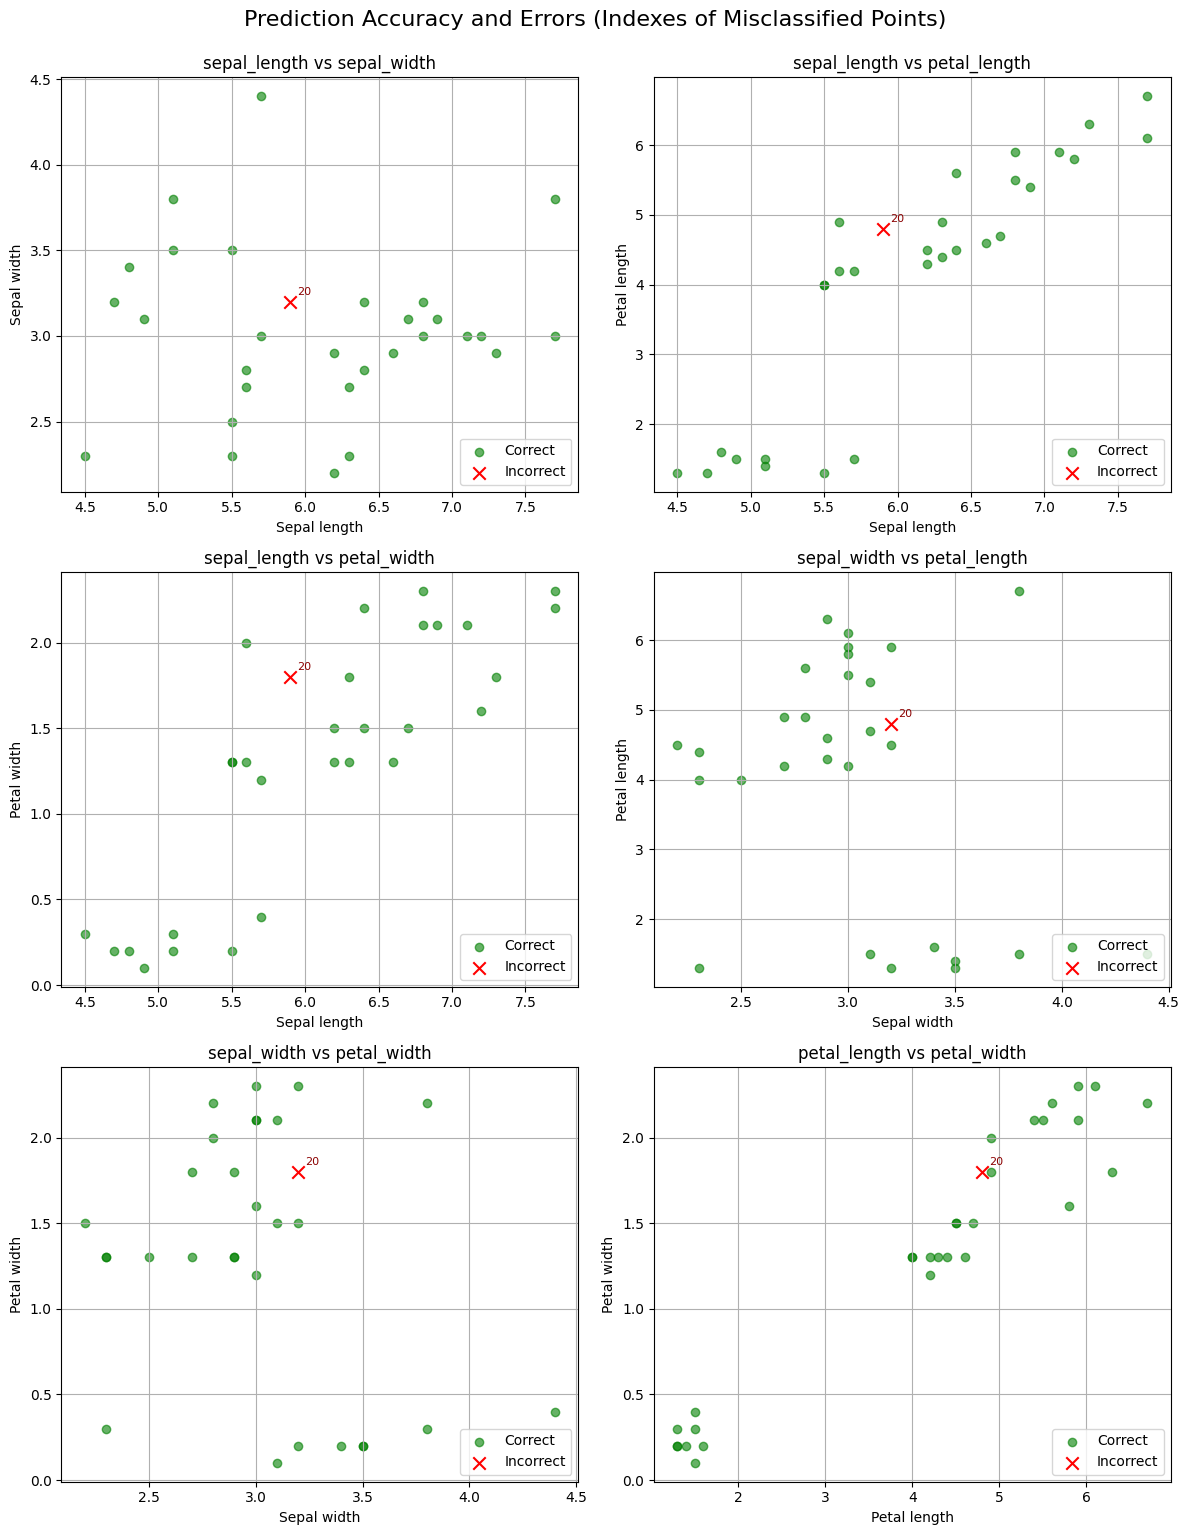

In [9]:
# Define feature column names
feature_cols = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']

# Create a boolean mask for incorrect predictions
incorrect = df_test_iris['real_label'] != df_test_iris['predicted_label']

# All feature pairs
feature_pairs = list(itertools.combinations(feature_cols, 2))

# Set up plot grid
n = len(feature_pairs)
cols = 2
rows = (n + 1) // cols

plt.figure(figsize=(6 * cols, 5 * rows))

for i, (feat_x, feat_y) in enumerate(feature_pairs, 1):
    plt.subplot(rows, cols, i)

    # Plot correct predictions
    plt.scatter(
        df_test_iris.loc[~incorrect, feat_x],
        df_test_iris.loc[~incorrect, feat_y],
        c='green', label='Correct', alpha=0.6
    )

    # Plot incorrect predictions
    wrong_points = df_test_iris.loc[incorrect]
    plt.scatter(
        wrong_points[feat_x],
        wrong_points[feat_y],
        c='red', label='Incorrect', marker='x', s=80
    )

    # Annotate incorrect predictions with index only
    for idx, row in wrong_points.iterrows():
        plt.annotate(
            f"{idx}",
            (row[feat_x], row[feat_y]),
            textcoords="offset points", xytext=(5,5), ha='left',
            fontsize=8, color='darkred'
        )

    plt.xlabel(feat_x.replace('_', ' ').capitalize())
    plt.ylabel(feat_y.replace('_', ' ').capitalize())
    plt.title(f'{feat_x} vs {feat_y}')
    plt.grid(True)
    plt.legend(loc='lower right')

plt.tight_layout()
plt.suptitle('Prediction Accuracy and Errors (Indexes of Misclassified Points)', fontsize=16, y=1.02)
plt.show()

We can see that only one label was misclassified. Let’s take a closer look at it.

In [10]:
df_test_iris['correct'] = df_test_iris.real_label == df_test_iris.predicted_label
df_test_iris

,sepal_length,sepal_width,petal_length,petal_width,real_label,predicted_label,correct
0,6.9,3.1,5.4,2.1,virginica,virginica,True
1,6.8,3.2,5.9,2.3,virginica,virginica,True
2,4.8,3.4,1.6,0.2,setosa,setosa,True
3,7.3,2.9,6.3,1.8,virginica,virginica,True
4,7.1,3.0,5.9,2.1,virginica,virginica,True
5,7.2,3.0,5.8,1.6,virginica,virginica,True
6,6.3,2.3,4.4,1.3,versicolor,versicolor,True
7,6.4,2.8,5.6,2.2,virginica,virginica,True
8,5.1,3.8,1.5,0.3,setosa,setosa,True
9,6.4,3.2,4.5,1.5,versicolor,versicolor,True


The misclassified point is located at index 20, where the true label was versicolor but the model predicted virginica. Still, this is an excellent result for a simple model like KNN.

Just before finish, **be aware if you’re working with many features, apply dimensionality reduction techniques (like PCA or feature selection) before using KNN**.

The K-Nearest Neighbors (KNN) algorithm struggles with high-dimensional datasets due to the curse of dimensionality. As the number of features increases:

- All data points become increasingly equidistant, making it difficult to distinguish between near and far neighbors.
- In high-dimensional spaces, even irrelevant or noisy points can appear as close neighbors.

Curse of dimensionality: 100%|██████████| 1000/1000 [01:02<00:00, 16.11it/s]


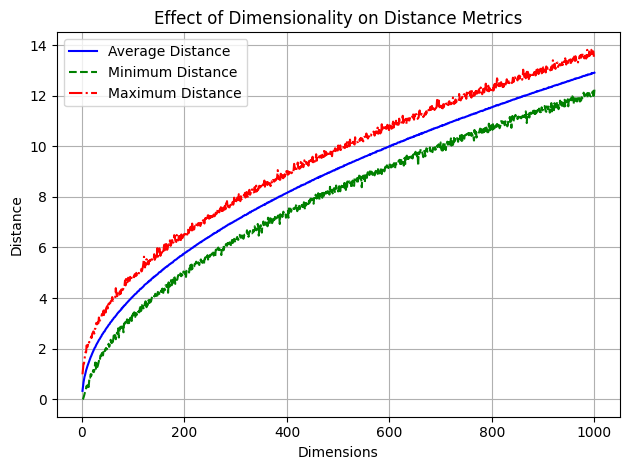

In [11]:
# Curse of dimensionality
def random_point(dim: int) -> Vector:
    return [random.random() for _ in range(dim)]

def random_distances(dim: int, num_points: int) -> List[float]:
    return [distance(random_point(dim), random_point(dim)) for _ in range(num_points)]

dimensions = range(1, 1001)
avg_distances = []
min_distances = []
max_distances = []

random.seed(12)
for dim in tqdm.tqdm(dimensions, desc="Curse of dimensionality"):
    distances = random_distances(dim, 1000)
    avg_distances.append(mean(distances))
    min_distances.append(min(distances))
    max_distances.append(max(distances))


# Line plots (no markers)
plt.plot(dimensions, avg_distances, label='Average Distance', linestyle='-', color='blue')
plt.plot(dimensions, min_distances, label='Minimum Distance', linestyle='--', color='green')
plt.plot(dimensions, max_distances, label='Maximum Distance', linestyle='-.', color='red')

# Labels and title
plt.xlabel('Dimensions')
plt.ylabel('Distance')
plt.title('Effect of Dimensionality on Distance Metrics')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

But there’s something even more interesting—and actually more concerning.
In low-dimensional datasets, the nearest points tend to be significantly closer than the average. However, as dimensionality increases, this contrast fades away:

- In high-dimensional spaces, the closest neighbor is almost as far as a randomly chosen point.

This is a serious issue because KNN—and many distance-based algorithms—rely on meaningful differences in distances. When that contrast disappears, their effectiveness can degrade dramatically.

Curse of dimensionality: 100%|██████████| 99/99 [00:00<00:00, 145.67it/s]


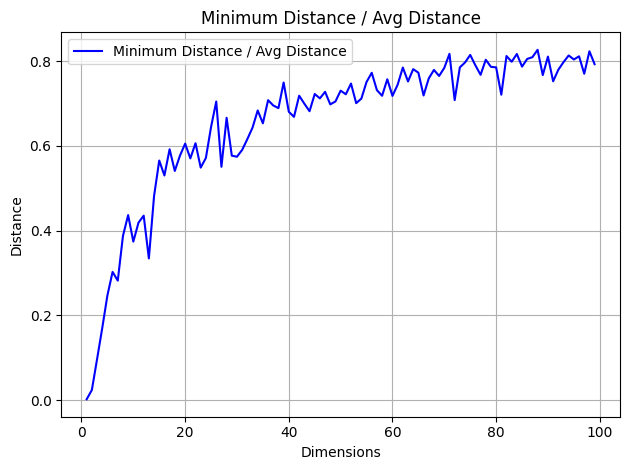

In [12]:
dimensions = range(1, 100)
avg_distances = []
min_distances = []
max_distances = []

random.seed(12)
for dim in tqdm.tqdm(dimensions, desc="Curse of dimensionality"):
    distances = random_distances(dim, 1000)
    avg_distances.append(mean(distances))
    min_distances.append(min(distances))

ratio = [min_distance/avg_distance for min_distance, avg_distance in zip(min_distances, avg_distances)]

# Line plots (no markers)
plt.plot(dimensions, ratio, label='Minimum Distance / Avg Distance', linestyle='-', color='blue')

# Labels and title
plt.xlabel('Dimensions')
plt.ylabel('Distance')
plt.title('Minimum Distance / Avg Distance')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### **Conclusion**

In this project, we explored the K-Nearest Neighbors (KNN) algorithm using the classic Iris dataset. KNN proved effective at classifying data based on feature similarity, achieving strong results with minimal complexity and no training phase.

Through visualizations and manual implementation, we saw how well the features separate the species—and how KNN uses distance to make decisions.

While KNN is a great starting point for understanding classification, it has clear limitations: it’s sensitive to noise, doesn’t scale well to large datasets, and can be computationally expensive at prediction time. Today, more advanced models like Random Forests, Support Vector Machines, and Neural Networks often outperform KNN in both speed and accuracy.

Nonetheless, KNN remains a valuable tool for learning and benchmarking simple classification tasks.